In [ ]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

import model_utils
import Plotter
from Frame import Frame
import pickle 
import numpy as np
import Utils
import plotly.graph_objects as go
import plotly.io as pio

path_to_mesh = 'C:/Users/Roni/Documents/gaussian_reconstruction/mesh'
image_path =  f'I:/My Drive/Research/gaussian_splatting/gaussian_splatting_input/mov9_cornell/'
dict_path = 'I:/My Drive/Research/gaussian_splatting/gaussian_splatting_input/mov9_cornell/dict/frames_model_cornell.pkl'
frame = 1765



with open(dict_path, 'rb') as file:
    data_dict = pickle.load(file)


root,body,right_wing,left_wing,list_joints_pitch_update = model_utils.initilize_skeleton_and_skin(path_to_mesh,skeleton_scale=1/1000)
joint_list,skin,weights,bones = model_utils.build_skeleton(root,body,right_wing,left_wing)


frames_per_cam = [Frame(image_path,frame,cam_num,frames_dict = data_dict) for cam_num in range(4)]
camera_pixel = np.vstack([frame.camera_center_to_pixel_ray(([frame.cm[0],frame.cm[1]])) for frame in  frames_per_cam])
camera_center = np.vstack([frame.X0.T for frame in  frames_per_cam])
cm_point = Utils.triangulate_least_square(camera_center,camera_pixel)
ew_to_lab = list(data_dict[frame][1].values())[0]['ew_to_lab']
cm_point_lab = ew_to_lab @ cm_point

fig = go.Figure()
Plotter.plot_skeleton(bones,fig,{},line_dict = {'width' : 10}, name = ['neck_head','wing','neck_thorax','thorax_abdomen','right_wing','right_wing_center1','right_wing_center2','left_wing','left_wing_center1','left_wing_center1'])
Plotter.plot_skin(fig,body.ptcloud_skin,'skin',skip_skin_points = 1,color = 'lime',size = 3)
Plotter.plot_skin(fig,right_wing.ptcloud_skin,'skin',skip_skin_points = 1,color = 'firebrick',size = 3)
Plotter.plot_skin(fig,left_wing.ptcloud_skin,'skin',skip_skin_points = 1,color = 'slateblue',size = 3)

fig.show()



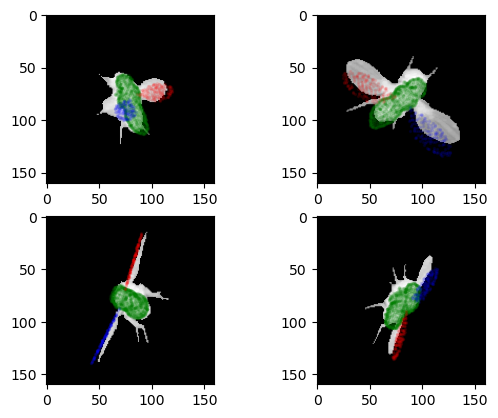

In [12]:

import Plotters
body_angles = np.array([-0, -0, 240 ])
left_wing_angles = np.array([-0.0 , 20.0 ,   10.0])
right_wing_angles = np.array([ 0.0  , 20.0 ,  0.0])

right_wing_angles_joint1,right_wing_angles_joint2,right_wing_twist_joint1,right_wing_twist_joint2 = 0.0,0.0,-0.0,-0.0
left_wing_angles_joint1,left_wing_angles_joint2,left_wing_twist_joint1,left_wing_twist_joint2 = -0.0,-0.0,0.0,0.0


means3D = model_utils.transform_pose(skin,weights,body_angles,list_joints_pitch_update,joint_list,bones,cm_point_lab,right_wing_angles,
                   left_wing_angles,right_wing_angles_joint1,left_wing_angles_joint1,
                   right_wing_twist_joint1,left_wing_twist_joint1,right_wing_angles_joint2,left_wing_angles_joint2,
                   right_wing_twist_joint2,left_wing_twist_joint2)
means3D_ew = (ew_to_lab.T @ means3D.T).T

body_ew = means3D_ew[:body.ptcloud_skin.shape[0],:]
rw_ew = means3D_ew[body.ptcloud_skin.shape[0]:body.ptcloud_skin.shape[0]+right_wing.ptcloud_skin.shape[0],:]
lw_ew = means3D_ew[body.ptcloud_skin.shape[0]+right_wing.ptcloud_skin.shape[0]:body.ptcloud_skin.shape[0]+right_wing.ptcloud_skin.shape[0] + left_wing.ptcloud_skin.shape[0],:]


body_model = means3D[:body.ptcloud_skin.shape[0],:]
rw_model = means3D[body.ptcloud_skin.shape[0]:body.ptcloud_skin.shape[0]+right_wing.ptcloud_skin.shape[0],:]
lw_model = means3D[body.ptcloud_skin.shape[0]+right_wing.ptcloud_skin.shape[0]:body.ptcloud_skin.shape[0]+right_wing.ptcloud_skin.shape[0] + left_wing.ptcloud_skin.shape[0],:]


ax = Plotters.plot_projections(body_ew[::1,:],frames_per_cam, color = 'green', alpha = 0.1)
ax = Plotters.plot_projections(rw_ew[::10,:],frames_per_cam, color = 'red', ax = ax, alpha = 0.1)
ax = Plotters.plot_projections(lw_ew[::10,:],frames_per_cam, color = 'blue', ax = ax, alpha = 0.1)

fig = go.Figure()
Plotter.plot_skeleton(bones,fig,{},line_dict = {'width' : 10}, name = ['neck_head','wing','neck_thorax','thorax_abdomen','right_wing','right_wing_center1','right_wing_center2','left_wing','left_wing_center1','left_wing_center1'])
Plotter.plot_skin(fig,body_model,'skin',skip_skin_points = 1,color = 'lime',size = 3)
Plotter.plot_skin(fig,rw_model,'skin',skip_skin_points = 1,color = 'firebrick',size = 3)
Plotter.plot_skin(fig,lw_model,'skin',skip_skin_points = 1,color = 'slateblue',size = 3)

